## GRU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
df = pd.read_csv("./wfp_food_prices_vnm.csv", 
                 parse_dates=['date'], index_col='date')
df[df.index.year == 2019]

FileNotFoundError: [Errno 2] No such file or directory: './UTE/wfp_food_prices_vnm.csv'

In [ ]:
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Price', {'fontsize': 12})

In [ ]:
df['price'] = df.groupby(df.index)['price'].transform('mean')
df = df.sort_index()

In [ ]:
df = df[df['price'] != 0]
df = df[df['admin1'] == 'An Giang']
df = df.drop_duplicates()

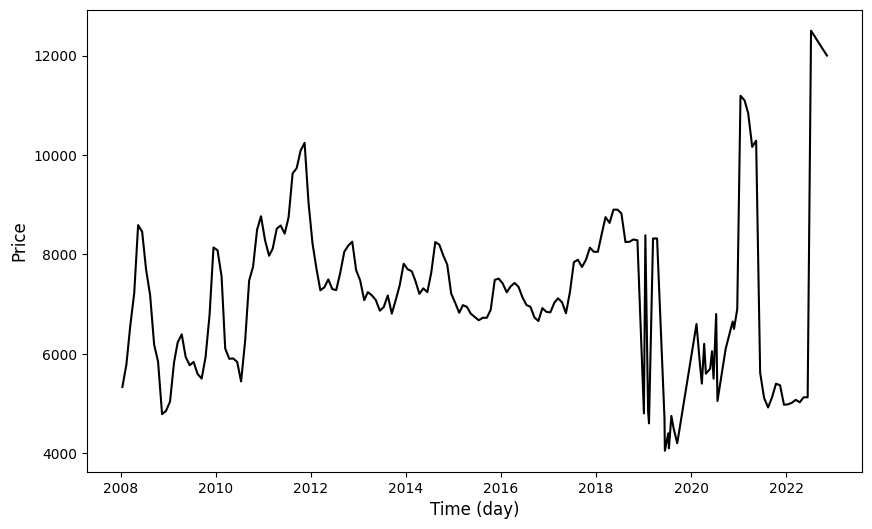

In [ ]:
dataset = df.copy()
timeseries(df.index, dataset['price'], 'Time (day)')

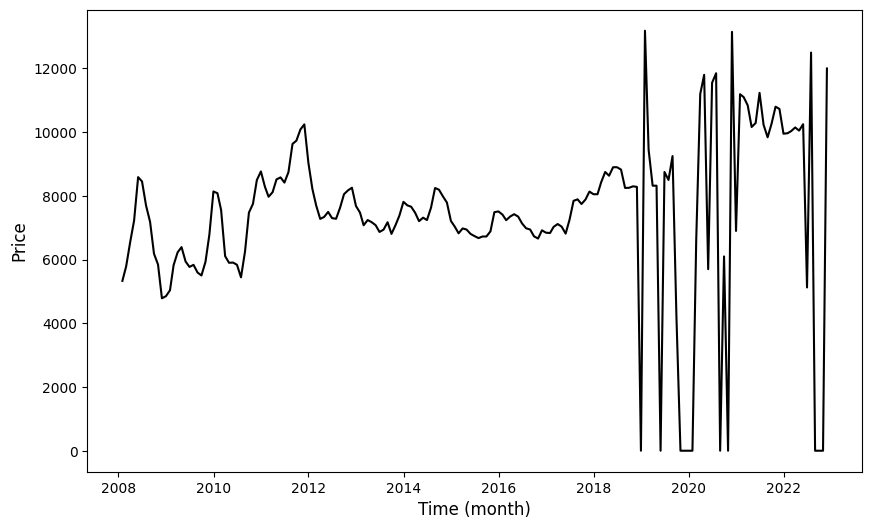

In [ ]:
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['price'], 'Time (month)')

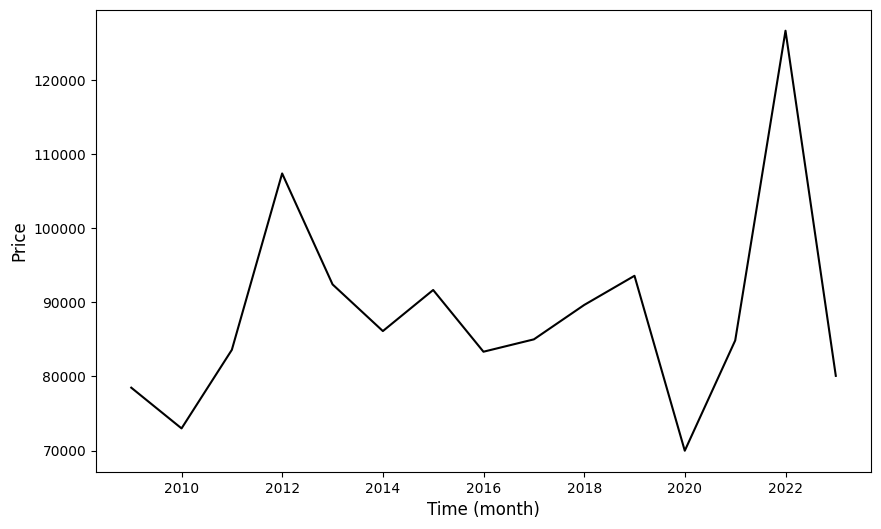

In [ ]:
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['price'], 'Time (month)')

In [ ]:
df.index

DatetimeIndex(['2008-01-15', '2008-02-15', '2008-03-15', '2008-04-15',
               '2008-05-15', '2008-06-15', '2008-07-15', '2008-08-15',
               '2008-09-15', '2008-10-15',
               ...
               '2022-02-15', '2022-03-15', '2022-03-15', '2022-04-15',
               '2022-04-15', '2022-05-15', '2022-05-15', '2022-06-15',
               '2022-07-11', '2022-11-10'],
              dtype='datetime64[ns]', name='date', length=190, freq=None)

In [ ]:
# Check for missing values
df = df.loc[:,['price']]
df.head()

price
date                
2008-01-15  5331.605
2008-02-15  5787.000
2008-03-15  6549.875
2008-04-15  7222.500
2008-05-15  8588.890

In [ ]:
print('Total num of missing values:') 
print(df.price.isna().sum())
print('')

Total num of missing values:
0



In [ ]:
df[df.index.duplicated()]

price
date                
2021-06-15  5617.500
2021-07-15  5115.000
2021-08-15  4920.000
2021-09-15  5130.000
2021-10-15  5400.000
2021-11-15  5365.000
2021-12-15  4976.000
2022-01-15  4983.200
2022-02-15  5016.668
2022-03-15  5074.000
2022-04-15  5025.000
2022-05-15  5125.000

In [ ]:
df = df.groupby('date', as_index=True).mean()
df.head()

price
date                
2008-01-15  5331.605
2008-02-15  5787.000
2008-03-15  6549.875
2008-04-15  7222.500
2008-05-15  8588.890

In [ ]:
df.shape

(178, 1)

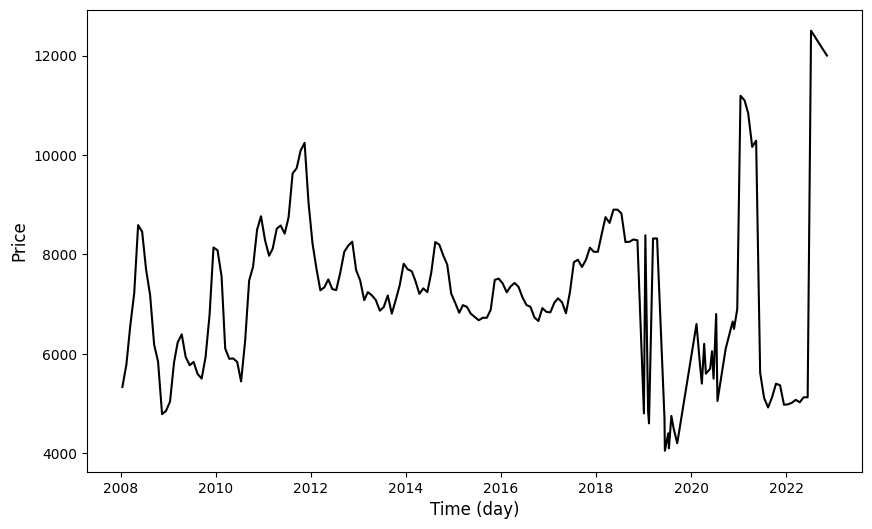

In [ ]:
dataset = df.copy()
timeseries(df.index, dataset['price'], 'Time (day)')

In [ ]:
# dataset = df.resample('D').ffill()
# dataset.shape

In [ ]:
# timeseries(dataset.index, dataset['price'], 'Time (day)')

In [ ]:
df = df.copy()
# Split train data and test data
train_size = int(len(df)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)
# Gia 12 thang
X_train, y_train = create_dataset(train_scaled,12)
X_test, y_test = create_dataset(test_scaled,12)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (130, 12, 1)
y_train.shape:  (130, 1)
X_test.shape:  (24, 12, 1)
y_test.shape:  (24, 1)


In [ ]:
X_test[:33].shape

(24, 12, 1)

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [ ]:
# Create BiLSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history

In [ ]:
history_gru = fit_model(model_gru)

Epoch 1/100
7/7 [==============================] - 4s 114ms/step - loss: 0.1255 - val_loss: 0.0616
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0379 - val_loss: 0.0751
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0155 - val_loss: 0.0563
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.0549
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0181 - val_loss: 0.0589
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0161 - val_loss: 0.0579
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0124 - val_loss: 0.0541
Epoch 8/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0150 - val_loss: 0.0548
Epoch 9/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0140 - val_loss: 0.0548
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0127 - val_loss: 0.0538
Epoch 11/100
7/7 [

In [ ]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
7/7 [==============================] - 7s 210ms/step - loss: 0.0960 - val_loss: 0.1616
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0358 - val_loss: 0.0690
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.0694
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0190 - val_loss: 0.0805
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0193 - val_loss: 0.0750
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0149 - val_loss: 0.0676
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0160 - val_loss: 0.0694
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.0717
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0146 - val_loss: 0.0680
Epoch 10/100
7/7 [==============================] - 0s 18ms/step - loss: 0.0145 - val_loss: 0.0673
Epoch 11/100
7/7 [

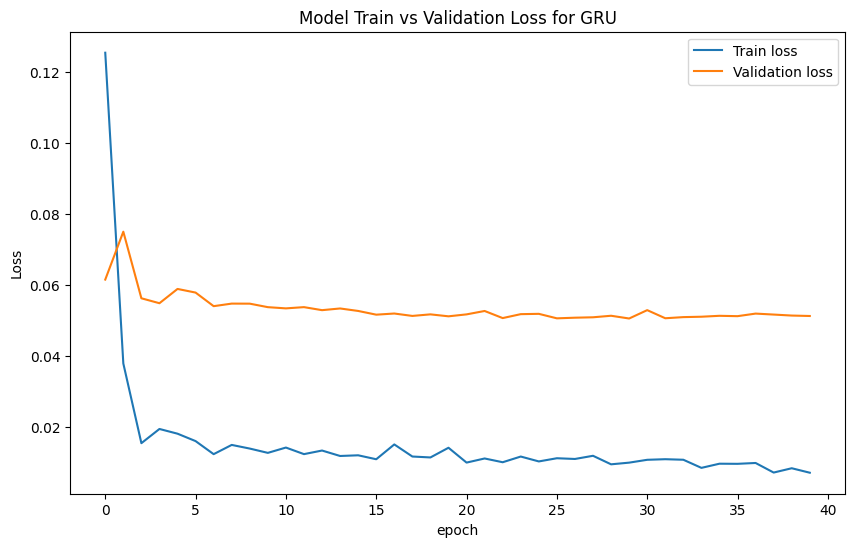

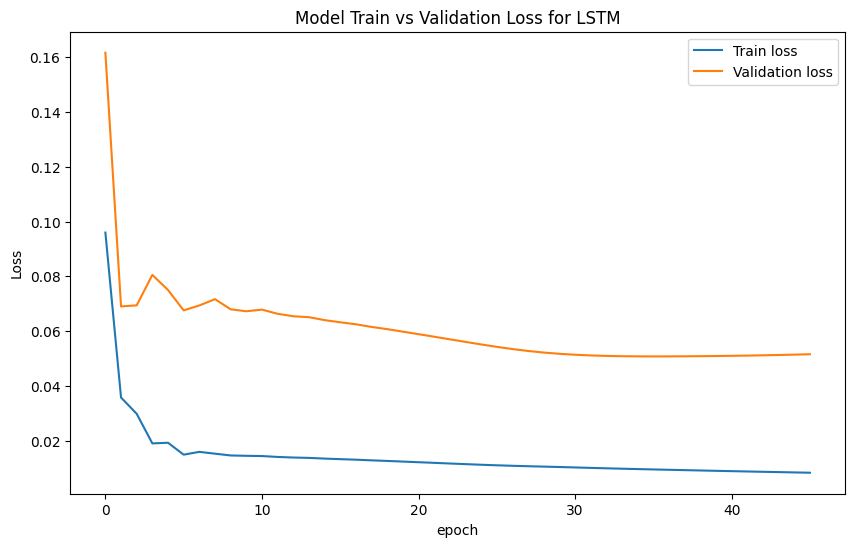

In [ ]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_lstm, 'LSTM')

In [ ]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)

1/1 [==============================] - 1s 579ms/step


GRU:
Mean Absolute Error: 1250.5011
Root Mean Square Error: 2042.1720



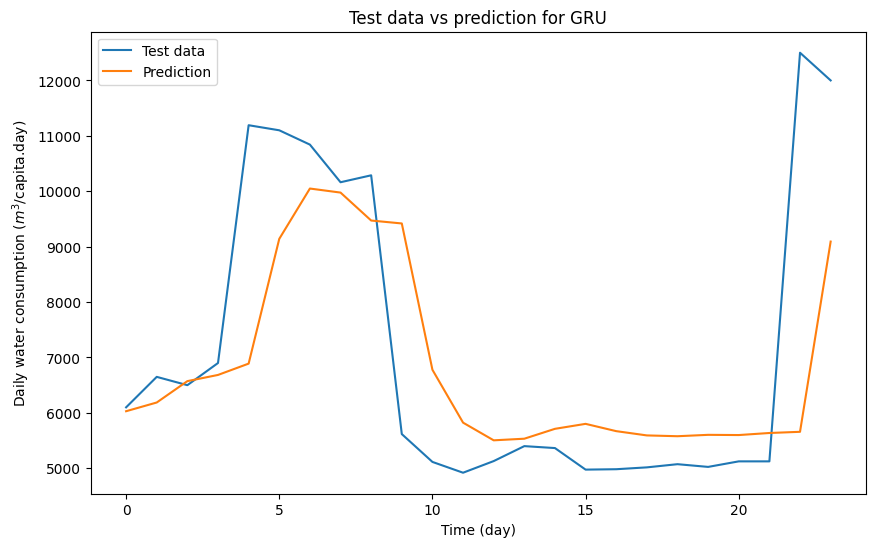

In [ ]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
       
plot_future(prediction_gru, 'GRU', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_gru, y_test, 'GRU')

In [ ]:
test_data.shape

(36, 1)

In [ ]:
# Select 60 days of data from test data
new_data = test_data[-50:]
scaled_data = scaler.transform(new_data)
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

X_30= create_dataset(scaled_data,12)

In [ ]:
X_30.shape

(24, 12, 1)

In [ ]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)

1/1 [==============================] - 0s 21ms/step


In [ ]:
model_gru.save("./model_gru.keras")

In [ ]:
print(prediction_gru)

[[ 6029.9883]
 [ 6187.392 ]
 [ 6572.964 ]
 [ 6684.7417]
 [ 6889.0913]
 [ 9140.744 ]
 [10048.842 ]
 [ 9975.848 ]
 [ 9471.458 ]
 [ 9418.588 ]
 [ 6778.121 ]
 [ 5823.8813]
 [ 5504.6953]
 [ 5533.9434]
 [ 5712.2417]
 [ 5801.97  ]
 [ 5670.301 ]
 [ 5593.29  ]
 [ 5578.7573]
 [ 5603.712 ]
 [ 5599.7993]
 [ 5636.933 ]
 [ 5658.377 ]
 [ 9091.655 ]]


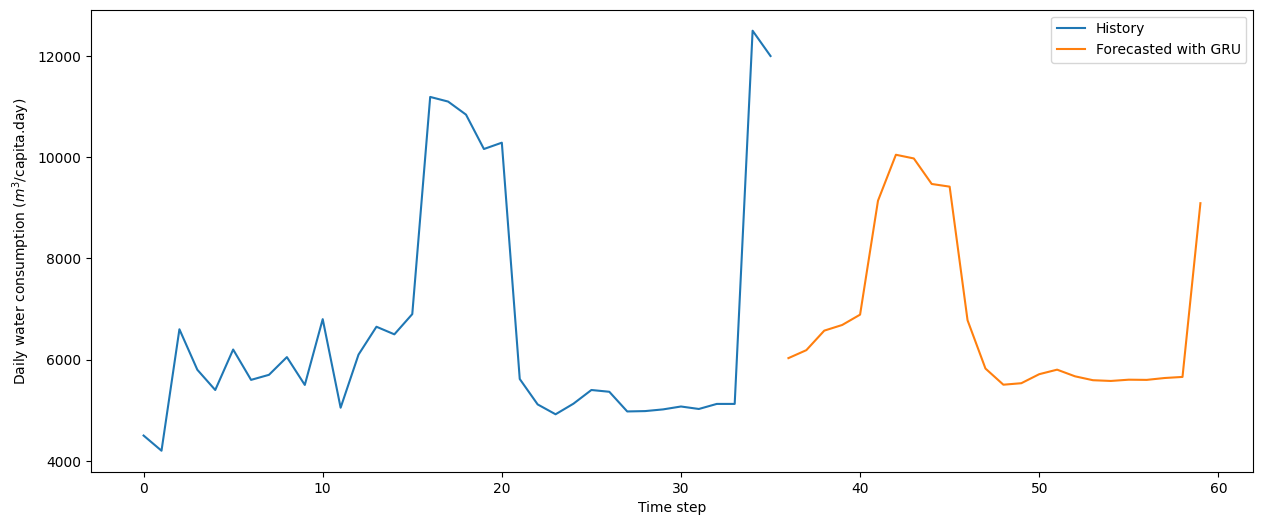

In [ ]:
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with GRU')
    
    plt.legend(loc='upper right')
    plt.xlabel('Time step')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
   
    
plot_multi_step(new_data, prediction_gru)